In [1]:
import numpy as np
import sympy as sym
import scipy
from numpy import cosh, sinh
from scipy.integrate import quad, dblquad, tplquad
from matplotlib import pyplot as plt

from scipy.special import hyp2f1

from scipy.interpolate import CloughTocher2DInterpolator

import mpmath

In [6]:
mode = 'num'
if mode == 'num':
    mod = np
    H = 0.2
    T = 1
    kappa = 0.1
    beta_inc = scipy.special.betainc
    gamma = scipy.special.gamma

    t_span = np.concatenate([ 
        np.linspace(0, 0.1, 100, endpoint=False),
        np.linspace(0.1, 0.9, 100, endpoint=False),
        np.linspace(0.9, 1.0, 100),
    ])
    
elif mode == 'sym':
    mod = sym
    H = sym.Symbol('H')
    T = sym.Symbol('T')
    t = sym.Symbol('t')
    s = sym.Symbol('s')
    u = sym.Symbol('u')
    v = sym.Symbol('v')
    kappa = sym.Symbol('\kappa')
    beta_inc = lambda a, b, x: sym.betainc(a, b, 0, x)
    gamma = sym.gamma
    
tau = lambda t: (T-t)/np.sqrt(kappa)

/var/folders/xr/jyb9qx9525v78pfvgjv4kfn40000gp/T/ipykernel_31000/846138070.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  r = s**(H - 1/2) * H / c_H
/var/folders/xr/jyb9qx9525v78pfvgjv4kfn40000gp/T/ipykernel_31000/846138070.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  r += c_H * (t / s)**(H - 1/2) * (t-s)**(H-1/2)


ValueError: x and y must have same first dimension, but have shapes (300,) and (100,)

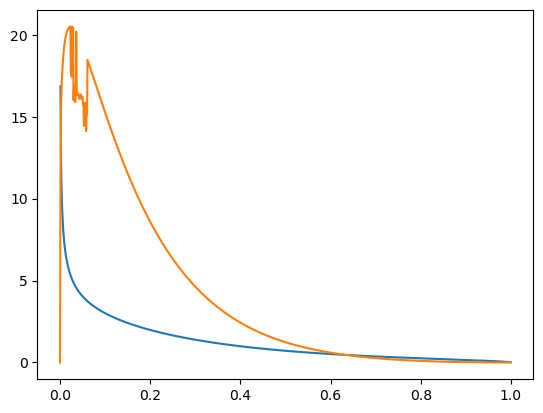

In [7]:
for H in [0.1, .2, .3, .4, .6, .7, .8, .9, .999]:
        
    c2_H = 2*H * gamma(3/2 - H) / ( gamma(H + 1/2) * gamma(2 - 2*H))
    c_H = mod.sqrt(c2_H)
    
    def z(t, s):
        r = s**(H - 1/2) * H / c_H
        r *= 1 - beta_inc(1-2*H, H+1/2, s/t)
        r += c_H * (t / s)**(H - 1/2) * (t-s)**(H-1/2)
        return r

    def z_prime(t,s):
        return c_H * (H - 0.5) * s ** (0.5 - H) * t ** (H - 0.5) * (t - s) ** (H - 1.5)
    
    def z_(t,s):
        f = lambda u: u**(H-3/2) * (u-s)**(H-0.5)
        res = quad(f, s, t, points=[s, t], full_output=1)[0]
        res *= - (H-0.5) * s**(0.5 - H)
        res += (t/s)**(H-0.5) * (t-s)**(H-1/2)
        res *= c_H
        return res

    if H > 0.5:
        z = z_
    else:
        for _ in range(100):
            t = np.random.uniform()
            s = np.random.uniform(0, t)
            assert np.allclose(z(t,s), z_(t,s)), "{}, {}".format(z(t,s), z_(t,s))
        
    def alpha_raw(t, s):
        f = lambda u: z(u, s) * cosh(tau(u))

        return quad(f, t, T, points=[t, T], full_output=1)[0]

    def overline_alpha_raw(t, s):
        f = lambda u: z_prime(u, s)*sinh(tau(u))

        return quad(f, t, T, points=[t, T], full_output=1)[0]

    #tss = [ (t_, s_)  for t_ in np.linspace(0, T, N)[1:] for s_ in np.linspace(0, t_, N)[1:-1]]
    #vss = [overline_alpha_raw(t_,s_) for (t_,s_) in tss ]
    #overline_alpha = CloughTocher2DInterpolator(tss, vss)

    def beta_raw(t):
        f = lambda s: overline_alpha_raw(t,s)**2
        #def f(s):
        #    if s == 0:
        #        return 0
        #    else:
        #        return z(t, s)*sinh(tau(t)) - alpha_raw(t,s)/np.sqrt(kappa) 
        return quad(f, 0, t, points=[0, t], full_output=1)[0]

    #def fun(u,v,t):
    #    res = hyp2f1(2-2*H, 1.5-H, 3+2*H, (u*t - v*t) / (u*v - t*v)) 
    #    res *= sinh(tau(u)) * sinh(tau(v)) * (u-t)**(2*H - 2) * v**(2*H - 2)
    #    res *= t**(2-2*H) / sinh(tau(t))**2
    #    res *= 2 * c2_H * (H-0.5)**2 * 0.5/(1-H)
    #    return res

    #def gfun(t):
    #    return min(t + 0.000001, T)
    #def qfun(t, v):
    #    return min(v + 0.000001, T)

    
    #ts = np.linspace(0, 1.0, N)
    plt.plot(t_span, [alpha_raw(s, s) for s in t_span])
    
    vs = [beta_raw(t) for t in t_span]
    beta = scipy.interpolate.PchipInterpolator(t_span, vs)
    plt.plot(t_span, vs)
    plt.plot(t_span, beta(t_span))
    plt.show()

    
    # Squared distance term
    f = lambda t: beta(t) / sinh(tau(t))**2
    sq_dist = 0.5 * quad(f, 0, T, points=[0, T], full_output=1)[0]
    #sq_dist = 0.5 * tplquad(fun, 0, T, gfun, T, qfun, T)[0]
    
    # QV term
    f = lambda s: alpha_raw(s, s)**2 / (np.sqrt(kappa) * sinh(tau(s))*cosh(tau(s)))
    qv_term = 0.5 * quad(f, 0, T)[0]
    
    print("H: {}, {} + {} = {}".format(H, sq_dist, qv_term,  qv_term + sq_dist))

In [ ]:
# kappa: H:
benchmarks = {
    0.1: {
        0.1: 0.27663653270507754,
        0.2: 0.2282496038086943,
        0.3: 0.1865656463817453,
        0.4: 0.1520298508153106,
        0.5: 0.12354603195750886,
        0.6: 0.09991167815488836,
        0.7: 0.08004846852273825,
        0.8: 0.06302855712136136,
        0.9: 0.048029497236016766,
        1.0: 0.035593882482059164,
    },
    0.01: {
        0.1: 0.20085137340115772,
        0.2: 0.1428418428389489,
        0.3: 0.09954529063458387,
        0.4: 0.06849005754875274,
        0.5: 0.04653426410750604,
        0.6: 0.03114831101100001,
        0.7: 0.02044020442056757,
        0.8: 0.013037332367746074,
        0.9: 0.00795731031703343,
        1.0: 0.004788375569560145,
    },
}

In [ ]:
# Cases H = 0.5 and H = 1.0
#H = 0.5
def penalty_value(H, x=0.0):
    if H == 0.5:
        return 0.5*np.sqrt(kappa)*np.tanh(T / np.sqrt(kappa)) * x**2 \
    + 0.5 * kappa * np.log(np.cosh(T / np.sqrt(kappa)))
    elif H == 1.0:
        return 0.5*np.sqrt(kappa)*np.tanh(T / np.sqrt(kappa)) * x**2 \
    + 0.5 * kappa * (T - 2 * np.sqrt(kappa) * np.tanh(0.5 * T / np.sqrt(kappa)))
    else:
        assert "H = {} is not supported".format(H)

In [ ]:
penalty_value(1.0)

In [ ]:
f = lambda u: (cosh(tau(t)) - 1)**2/sinh(tau(t))**2

In [ ]:
quad(f, 0, T)[0] * 0.5 * kappa